"""
SPEECh: Scalable Probabilistic Estimates of EV Charging

Code first published in October 2021.

Developed by Siobhan Powell (siobhan.powell@stanford.edu).
"""

# Cluster drivers

In [ ]:
s3_bucket_folder_address = '' # contained the location of our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM

## Load data

In [2]:
year = '2019'
driver_subset = pd.read_csv(s3_bucket_folder_address+'sessions'+year+'_driverdata_revised.csv', index_col=0)

In [4]:
cols_driver = driver_subset.columns[[2, 3]]
cols_cts = driver_subset.columns[[4, 5, 6, 7, 8]]
cols_work = driver_subset.columns[[9, 10, 11, 12]]
cols_mud = driver_subset.columns[[17, 18, 19, 20]]
cols_other_slow = driver_subset.columns[[25, 26, 27, 28]]
cols_home = driver_subset.columns[[33, 34, 35, 36]]
cols_other_fast = driver_subset.columns[[41, 42, 43, 44]]
cols_other_fast

Index(['MUD - Session energy - mean', 'MUD - Session time - mean',
       'MUD - Start hour - mean', 'MUD - Weekend fraction'],
      dtype='object')

In [5]:
main_cols = np.concatenate((cols_driver, cols_cts, cols_work, cols_home, cols_other_slow, cols_other_fast, cols_mud))

In [6]:
main_cols

array(['Num Zip Codes', 'Battery Capacity', 'Num Workplace Sessions',
       'Num Single Family Residential Sessions', 'Num MUD Sessions',
       'Num Other Slow Sessions', 'Num Other Fast Sessions',
       'Work - Session energy - mean', 'Work - Session time - mean',
       'Work - Start hour - mean', 'Work - Weekend fraction',
       'Other Fast - Session energy - mean',
       'Other Fast - Session time - mean',
       'Other Fast - Start hour - mean', 'Other Fast - Weekend fraction',
       'Other Slow - Session energy - mean',
       'Other Slow - Session time - mean',
       'Other Slow - Start hour - mean', 'Other Slow - Weekend fraction',
       'MUD - Session energy - mean', 'MUD - Session time - mean',
       'MUD - Start hour - mean', 'MUD - Weekend fraction',
       'Home - Session energy - mean', 'Home - Session time - mean',
       'Home - Start hour - mean', 'Home - Weekend fraction'],
      dtype=object)

## Clean and normalize

In [7]:
for col in main_cols:
    nanct = sum(np.isnan(driver_subset[col].values))
    if nanct > 0:
        print(col)

In [8]:
print('Num before: ',driver_subset.shape[0])
driver_subset = driver_subset.dropna(axis=0, subset=main_cols)
print('Num after: ',driver_subset.shape[0])

Num before:  38265
Num after:  38265


In [ ]:
def normalize_df(df, cols_keep):
    
    scaling_df = {'Col':[], 'Shift':[], 'Denom':[]}
    df_here = df.loc[:, cols_keep]
    for col in cols_keep:
        scaling_df['Col'].append(col)
        scaling_df['Shift'].append(df_here[col].min())
        scaling_df['Denom'].append(df_here[col].max()-df_here[col].min())
        df_here[col] = (df_here[col]-df_here[col].min())/(df_here[col].max()-df_here[col].min())
    scaling_df = pd.DataFrame(scaling_df)

    return df_here, scaling_df


In [17]:
X_df, scaling_df = normalize_df(driver_subset, main_cols)

## Hierarchical clustering

In [26]:
import scipy.cluster.hierarchy as shc

In [27]:
linkage = shc.linkage(X_df, method='ward')

In [29]:
np.save('linkage_matrix_2019.npy', linkage)

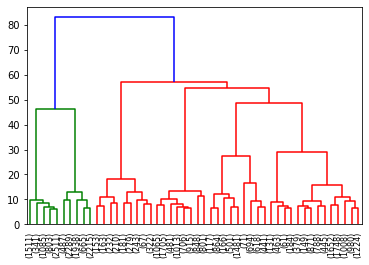

In [72]:
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=50, show_leaf_counts=True)

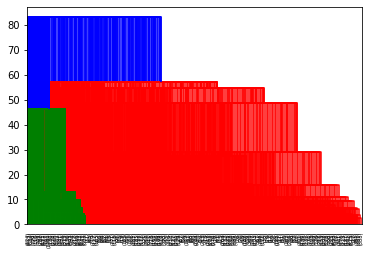

In [61]:
heights1 = []
heights2 = []
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 200)
for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), show_leaf_counts=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))#np.max(dend['dcoord'], axis=1)[1] - np.max(dend['dcoord'], axis=1)[0])#np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))

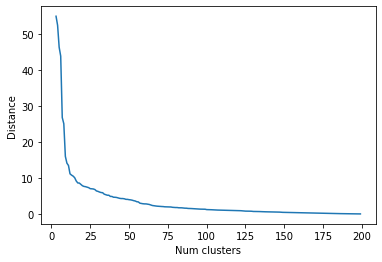

In [74]:
plt.figure()
plt.plot(nks, np.max(heights2)-heights2)
plt.xlabel('Num clusters')
plt.ylabel('Distance')
plt.show()

# close investigation of distance used to select optimal number of clusters

In [75]:
num_clusters = 16
ac = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward').fit_predict(X_df.values)

In [76]:
s3_bucket = ''
s3_folder = ''

np.save('linkage_matrix.npy', linkage)
s3 = boto3.client('s3')
s3.upload_file('linkage_matrix.npy', s3_bucket, s3_folder+'2019_linkage_revised.npy')

In [81]:
X_df['Agglom Cluster Number'] = ac
X_df.to_csv(s3_bucket_folder_address+'2019_scaled_revised.csv')
driver_subset['Agglom Cluster Number'] = ac
driver_subset.to_csv(s3_bucket_folder_address+'2019_unscaled_revised.csv')


# Plot dendrogram

In [ ]:
shc.set_link_color_palette(['#d7191c', '#fdae61', '#fee08b', '#abdda4', '#2b83ba'])
fig, ax = plt.subplots(figsize=(15,5))
labs_here = ['Small batt', 'Mixed batt', 'Large batt', '+ Work', '+ Public', '+ Work and Public', 'High Energy, W > P', 'Short, Afternoon, P > W', 'W >> P', 'MUD', 'High energy', 'Low energy + weekends', 'Low energy + home', '+ Fast', 'Low energy, W + P', 'W > P']#'WP & Some Other, small batt, frequent WP', 'WP & Some Other, small batt, less frequent WP', 'Includes Single Fam Res', 'Other & Some WP, big battery OR includes MUD', 'Other & Some WP, small battery']
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=16, show_leaf_counts=True, count_sort='ascending', color_threshold=47, ax=ax)
ax.set_xticklabels(labs_here, rotation=20, ha="right", rotation_mode="anchor")
ax.text(13, 60, s='Only Workplace', fontsize=14)
ax.text(40, 60, s='Mainly Residential', fontsize=14)
ax.text(90, 60, s='Public and Workplace', fontsize=14)
ax.text(79, 32, s='Large Battery', fontsize=14)
ax.text(112, 32, s='Mainly Public', fontsize=14)
ax.text(144, 32, s='Small Battery', fontsize=14)
ax.set_yticks([])
plt.tight_layout()
# plt.savefig('Revised_Cluster_Interpretation2.pdf', bbox_inches='tight')
plt.show()
